<a href="https://colab.research.google.com/github/amangupta2/ai_weather/blob/main/docs/source/wbx_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(quickstart)=
# WeatherBench-X Quickstart

<a target="_blank" href="https://colab.research.google.com/github/google-research/weatherbenchX/blob/main/docs/source/wbx_quickstart.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook goes through the basic components of WeatherBench-X.

## Imports

In [ ]:
# Note that pip might complain about some versions but the notebook should still work as expected.
!pip install git+https://github.com/google-research/weatherbenchX.git
#!pip install stationbench
!pip install cartopy
! pip install netCDF4

  Cloning https://github.com/google-research/weatherbenchX.git to /tmp/pip-req-build-vr8g7g4j
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbenchX.git /tmp/pip-req-build-vr8g7g4j
  Resolved https://github.com/google-research/weatherbenchX.git to commit 1eef163bb8e89fa9eaf5a8f928fbd33348f61462
  Preparing metadata (setup.py) ... done


In [ ]:
import apache_beam as beam
import numpy as np
import xarray as xr
import weatherbenchX
from weatherbenchX.data_loaders import xarray_loaders
from weatherbenchX.metrics import deterministic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation
from weatherbenchX import weighting
from weatherbenchX import binning
from weatherbenchX import time_chunks
from weatherbenchX import beam_pipeline
#import stationbench

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#
from netCDF4 import Dataset

**IMPORTANT: If you are running this on Colab, uncomment the cell below to access the cloud datasets.**

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

f = '/content/drive/MyDrive/ERA5_lsm.nc'
nc = Dataset(f)
lsm = nc.variables['lsm'][0,:,:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loaders

First, we define the data loaders for the data we would like to use. Data loaders can be implemented to read from any source. The only requirement is that they return data as an Xarray Dataset (or a dictionary of DataArrays).

It is the data loaders' job to make sure that the returned target and prediction datasets are aligned, i.e. have the same variable names and coordinates that can be broadcast against each other. If this is not the case (e.g. for sparse observations), interpolators can be used to align the data (see How To).

In this example, we will evaluate gridded HRES predictions against ERA5 targets. We will load the public Zarr datasets on the WeatherBench cloud bucket.

In [ ]:
# data guide: https://weatherbench2.readthedocs.io/en/latest/data-guide.html

# Ground truth to compare to
target_path_era5_analysis     = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
target_path_hres_analysis     = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'

# ============ AI + TRADITIONAL FORECASTS ====================
prediction_path_pangu         = 'gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
prediction_path_graphcast     = 'gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
prediction_path_fuxi          = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'

prediction_path_panguoper     = 'gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
prediction_path_graphcastoper = 'gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'

# traditional model forecasts
prediction_path_ifshres_forecast  = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
prediction_path_ifsens_forecast   = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr' # can remove "_mean" to get the full ensemble
prediction_path_era5_forecast     = 'gs://weatherbench2/datasets/era5-forecasts/2020-1440x721.zarr'

#prediction_path_neuralgcm    = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'
#prediction_path_sphericalcnn = ''gs://weatherbench2/datasets/sphericalcnn/2020-240x121_equiangular_with_poles.zarr''


In [87]:
A=xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721.zarr')

<ipython-input-87-e90757357bf3>:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721.zarr')


<xarray.Dataset> Size: 1PB
Dimensions:                   (time: 3652, number: 50,
                               prediction_timedelta: 61, latitude: 721,
                               longitude: 1440, level: 3)
Coordinates:
  * latitude                  (latitude) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * level                     (level) int32 12B 500 700 850
  * longitude                 (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * number                    (number) int32 200B 1 2 3 4 5 6 ... 46 47 48 49 50
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 488B 00:...
  * time                      (time) datetime64[ns] 29kB 2018-01-01 ... 2022-...
Data variables: (12/15)
    10m_u_component_of_wind   (time, number, prediction_timedelta, latitude, longitude) float32 46TB dask.array<chunksize=(1, 50, 1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind   (time, number, prediction_timedelta, latitude, longitude) float32 46TB dask.array<chunksize=(1, 50, 1, 721, 1440), meta=np.ndarray>
    10m_wind_speed            (time, number, prediction_timedelta, latitude, longitude) float32 46TB dask.array<chunksize=(1, 50, 1, 721, 1440), meta=np.ndarray>
    2m_temperature            (time, number, prediction_timedelta, latitude, longitude) float32 46TB dask.array<chunksize=(1, 50, 1, 721, 1440), meta=np.ndarray>
    geopotential              (time, number, prediction_timedelta, level, latitude, longitude) float32 139TB dask.array<chunksize=(1, 50, 1, 3, 721, 1440), meta=np.ndarray>
    mean_sea_level_pressure   (time, number, prediction_timedelta, latitude, longitude) float32 46TB dask.array<chunksize=(1, 50, 1, 721, 1440), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, number, prediction_timedelta, latitude, longitude) float32 46TB dask.array<chunksize=(1, 50, 1, 721, 1440), meta=np.ndarray>
    total_precipitation_24hr  (time, number, prediction_timedelta, latitude, longitude) float32 46TB dask.array<chunksize=(1, 50, 1, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr   (time, number, prediction_timedelta, latitude, longitude) float32 46TB dask.array<chunksize=(1, 50, 1, 721, 1440), meta=np.ndarray>
    u_component_of_wind       (time, number, prediction_timedelta, level, latitude, longitude) float32 139TB dask.array<chunksize=(1, 50, 1, 3, 721, 1440), meta=np.ndarray>
    v_component_of_wind       (time, number, prediction_timedelta, level, latitude, longitude) float32 139TB dask.array<chunksize=(1, 50, 1, 3, 721, 1440), meta=np.ndarray>
    wind_speed                (time, number, prediction_timedelta, level, latitude, longitude) float32 139TB dask.array<chunksize=(1, 50, 1, 3, 721, 1440), meta=np.ndarray>

In [77]:
# All datasets available at 6-hourly resolution
time1='2020-05-01T00:00:00.000000000'
time2='2020-05-05T18:00:00.000000000' # 02 to 05 for testing


ds_era5 = xr.open_zarr(
    target_path_era5_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_hres = xr.open_zarr(
    target_path_hres_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_pangu = xr.open_zarr(
    prediction_path_pangu,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcast = xr.open_zarr(
    prediction_path_graphcast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_fuxi = xr.open_zarr(
    prediction_path_fuxi,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_panguoper = xr.open_zarr(
    prediction_path_panguoper,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcastoper = xr.open_zarr(
    prediction_path_graphcastoper,
    chunks=None,
    storage_options=dict(token='anon'),
)


# traditional
ds_ifshres_fcst = xr.open_zarr(
    prediction_path_ifshres_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_ifsens_fcst = xr.open_zarr(
    prediction_path_ifsens_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_era5_fcst = xr.open_zarr(
    prediction_path_era5_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)

# forecast is made every 6 hours using initial conditions every 12 hours. so time axis has 2 samples per day, but the prediction_delta has 6 samples per timestamp
data_era5          = ds_era5.sel(time=slice(time1, time2))
data_hres          = ds_hres.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_pangu         = ds_pangu.sel(time=slice(time1, time1))
data_graphcast     = ds_graphcast.sel(time=slice(time1, time1))
data_fuxi          = ds_fuxi.sel(time=slice(time1, time1))
# --------------------------------------------------------------------
data_panguoper     = ds_panguoper.sel(time=slice(time1, time1))
data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time1))
# --------------------------------------------------------------------
data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time2))
data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time1))
data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time1))

print('Done')

<ipython-input-77-09fbcee09100>:18: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_pangu = xr.open_zarr(
<ipython-input-77-09fbcee09100>:23: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_graphcast = xr.open_zarr(
<ipython-input-77-09fbcee09100>:28: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_fuxi = xr.open_zarr(
<ipython-input-77-09fbcee09100>:35: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimede

Done


In [86]:
data_ifsens_fcst

<xarray.Dataset> Size: 7GB
Dimensions:                   (time: 1, prediction_timedelta: 61,
                               latitude: 721, longitude: 1440, level: 3)
Coordinates:
  * latitude                  (latitude) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * level                     (level) int32 12B 500 700 850
  * longitude                 (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 488B 00:...
  * time                      (time) datetime64[ns] 8B 2020-05-01
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, latitude, longitude) float32 253MB ...
    10m_v_component_of_wind   (time, prediction_timedelta, latitude, longitude) float32 253MB ...
    10m_wind_speed            (time, prediction_timedelta, latitude, longitude) float32 253MB ...
    2m_temperature            (time, prediction_timedelta, latitude, longitude) float32 253MB ...
    geopotential              (time, prediction_timedelta, level, latitude, longitude) float32 760MB ...
    mean_sea_level_pressure   (time, prediction_timedelta, latitude, longitude) float32 253MB ...
    ...                        ...
    total_precipitation       (time, prediction_timedelta, latitude, longitude) float32 253MB ...
    total_precipitation_24hr  (time, prediction_timedelta, latitude, longitude) float32 253MB ...
    total_precipitation_6hr   (time, prediction_timedelta, latitude, longitude) float32 253MB ...
    u_component_of_wind       (time, prediction_timedelta, level, latitude, longitude) float32 760MB ...
    v_component_of_wind       (time, prediction_timedelta, level, latitude, longitude) float32 760MB ...
    wind_speed                (time, prediction_timedelta, level, latitude, longitude) float32 760MB ...

In [78]:
#data_hres
#data_pangu
#data_graphcast
#data_fuxi

p1=0
p2=20 # 8

lat = data_era5['latitude'].values
lon = data_era5['longitude'].values

#p_era5 = data_era5['level'].values
t_era5 = data_era5['2m_temperature']
u_era5 = data_era5['10m_u_component_of_wind']
v_era5 = data_era5['10m_v_component_of_wind']

#p_hres = data_hres['level'].values
t_hres = data_hres['2m_temperature'].values
u_hres = data_hres['10m_u_component_of_wind'].values
v_hres = data_hres['10m_v_component_of_wind'].values

#p_pangu = data_pangu['level'].values
t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_graphcast = data_graphcast['level'].values
t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_fuxi = data_fuxi['level'].values
t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_panguoper = data_panguoper['level'].values
t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'].values
u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'].values
v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'].values

t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1:p2,:,:].values
u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1:p2,:,:].values
u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

# example
#t_fuxi.shape

In [85]:
data_ifsens_fcst['2m_temperature'].shape

(1, 61, 721, 1440)

In [79]:
# Compute latitude weighted RMSE wrt ERA5: globally and over India
def RMSE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  rmse_global = np.sqrt(np.mean(np.mean(anom**2,2),1)) #np.sqrt(np.mean(np.mean(anom**2,2)*factor[np.newaxis,:],1)/np.mean(factor))
  rmse_india  = np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2),1)) #np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2)*factor2[np.newaxis,:],1)/np.mean(factor2))

  return rmse_global, rmse_india

# Compute latitude-weighted MAE: globally and over India
def MAE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  mae_global = np.mean(np.mean(np.abs(anom),2),1)
  mae_india  = np.mean(np.mean(np.abs(anom)[:,208:329,272:393],2),1)

  return mae_global, mae_india


# Compute latitude-weighted anomaly correlation coefficient: globally and over India
def ACC(pred, truth, lat):
  ...

In [81]:
# ---------- RMSE for ERA5 initialized models ------------------------------
rmse_pangu_global    , rmse_pangu_india     = RMSE(t_pangu,t_era5,lat)
rmse_graphcast_global, rmse_graphcast_india = RMSE(t_graphcast,t_era5,lat)
rmse_fuxi_global     , rmse_fuxi_india      = RMSE(t_fuxi,t_era5,lat)
rmse_era5fcst_global , rmse_era5fcst_india  = RMSE(t_era5_fcst,t_era5,lat) # TRADITIONAL
# ---------- MAE for ERA5 initialized models ------------------------------
mae_pangu_global    , mae_pangu_india     = MAE(t_pangu,t_era5,lat)
mae_graphcast_global, mae_graphcast_india = MAE(t_graphcast,t_era5,lat)
mae_fuxi_global     , mae_fuxi_india      = MAE(t_fuxi,t_era5,lat)
mae_era5fcst_global , mae_era5fcst_india  = MAE(t_era5_fcst,t_era5,lat) # TRADITIONAL


# ---------- RMSE for HRES initialized models) -----------------------------
rmse_panguoper_global    , rmse_panguoper_india     = RMSE(t_panguoper,t_hres,lat)
rmse_graphcastoper_global, rmse_graphcastoper_india = RMSE(t_graphcastoper,t_hres,lat)
rmse_ifshres_fcst_global , rmse_ifshres_fcst_india  = RMSE(t_ifshres_fcst,t_hres,lat)
rmse_ifsens_fcst_global  , rmse_ifsens_fcst_india  = RMSE(t_ifsens_fcst,t_hres,lat) # TRADITIONAL
# ---------- MAE for HRES initialized models) -----------------------------
mae_panguoper_global    , mae_panguoper_india     = MAE(t_panguoper,t_hres,lat)
mae_graphcastoper_global, mae_graphcastoper_india = MAE(t_graphcastoper,t_hres,lat)
mae_ifshres_fcst_global , mae_ifshres_fcst_india  = MAE(t_ifshres_fcst,t_hres,lat) # TRADITIONAL
mae_ifsens_fcst_global  , mae_ifsens_fcst_india   = MAE(t_ifsens_fcst,t_hres,lat) # TRADITIONAL


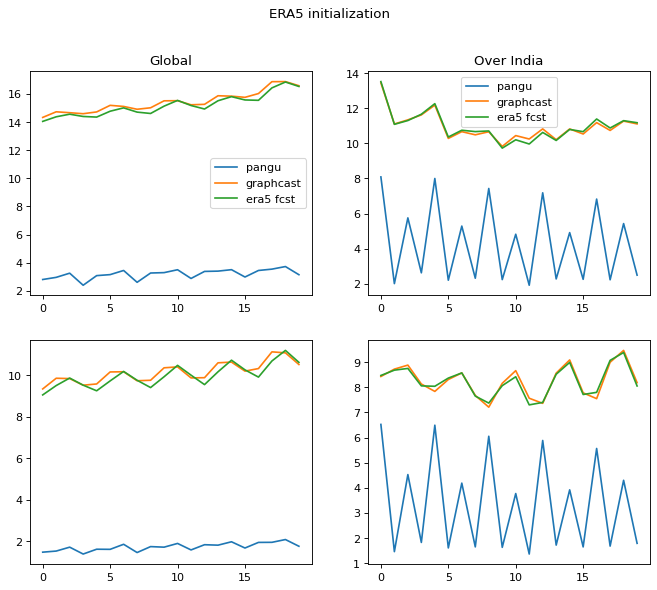

In [82]:
# RMSE AND MAE FOR ERA5 initialization

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('ERA5 initialization')
plt.subplot(221)
plt.plot(rmse_pangu_global, label='pangu')
plt.plot(rmse_graphcast_global, label='graphcast')
plt.plot(rmse_era5fcst_global, label='era5 fcst')
#plt.plot(rmse_fuxi_global)
plt.title('Global')
plt.legend()

plt.subplot(222)
plt.plot(rmse_pangu_india, label='pangu')
plt.plot(rmse_graphcast_india, label='graphcast')
plt.plot(rmse_era5fcst_india, label='era5 fcst')
#plt.plot(rmse_fuxi_india)
plt.title('Over India')
plt.legend()

plt.subplot(223)
plt.plot(mae_pangu_global, label='pangu')
plt.plot(mae_graphcast_global, label='graphcast')
plt.plot(mae_era5fcst_global, label='era5 fcst')
#plt.plot(rmse_fuxi_global)
#plt.legend()

plt.subplot(224)
plt.plot(mae_pangu_india, label='pangu')
plt.plot(mae_graphcast_india, label='graphcast')
plt.plot(mae_era5fcst_india, label='era5 fcst')
#plt.plot(rmse_fuxi_global)
#plt.legend()

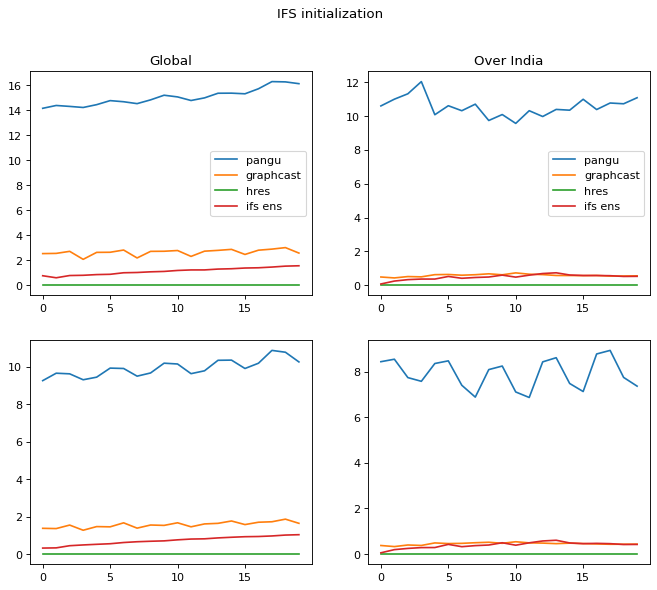

In [83]:
# RMSE AND MAE FOR IFS HRES initialization

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('IFS initialization')
plt.subplot(221)
plt.plot(rmse_panguoper_global, label='pangu')
plt.plot(rmse_graphcastoper_global, label='graphcast')
plt.plot(rmse_ifshres_fcst_global, label='hres')
plt.plot(rmse_ifsens_fcst_global, label='ifs ens')
plt.title('Global')
plt.legend()

plt.subplot(222)
plt.plot(rmse_panguoper_india, label='pangu')
plt.plot(rmse_graphcastoper_india, label='graphcast')
plt.plot(rmse_ifshres_fcst_india, label='hres')
plt.plot(rmse_ifsens_fcst_india, label='ifs ens')
#plt.plot(rmse_fuxi_india)
plt.title('Over India')
plt.legend()

plt.subplot(223)
plt.plot(mae_panguoper_global, label='pangu')
plt.plot(mae_graphcastoper_global, label='graphcast')
plt.plot(mae_ifshres_fcst_global, label='hres')
plt.plot(mae_ifsens_fcst_global, label='ifs ens')

#plt.plot(rmse_fuxi_global)
#plt.legend()

plt.subplot(224)
plt.plot(mae_panguoper_india, label='pangu')
plt.plot(mae_graphcastoper_india, label='graphcast')
plt.plot(mae_ifshres_fcst_india, label='hres')
plt.plot(mae_ifsens_fcst_india, label='ifs ens')
#plt.plot(rmse_fuxi_global)
#plt.legend()

In [ ]:
# Running over multiple days


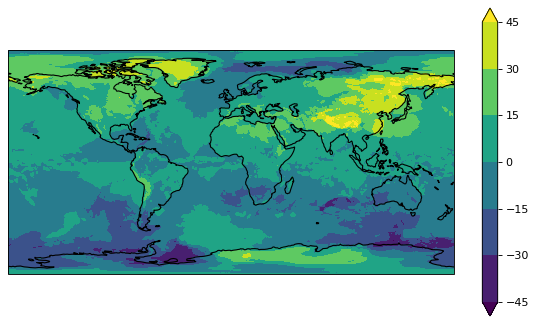

In [ ]:
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=1)

C=plt.contourf(lon,lat,dt_fuxi[0,:,:], extend='both')
plt.colorbar()

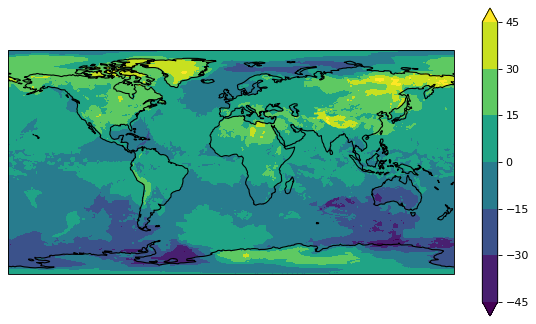

In [ ]:
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=1)

C=plt.contourf(lon,lat,dt_fuxi[1,:,:], extend='both')
plt.colorbar()

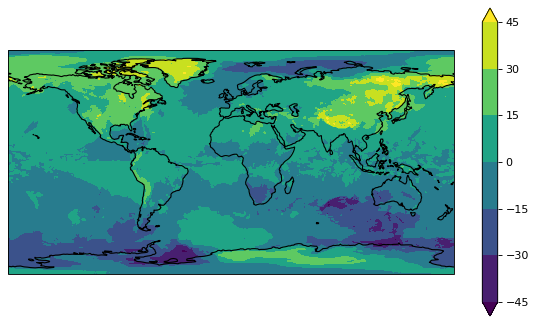

In [ ]:
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=1)

C=plt.contourf(lon,lat,dt_fuxi[2,:,:], extend='both')
plt.colorbar()

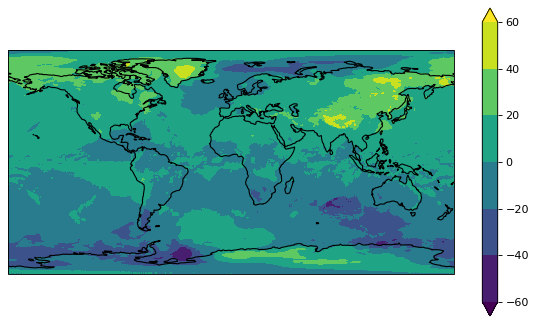

In [ ]:
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=1)

C=plt.contourf(lon,lat,dt_fuxi[3,:,:], extend='both')
plt.colorbar()

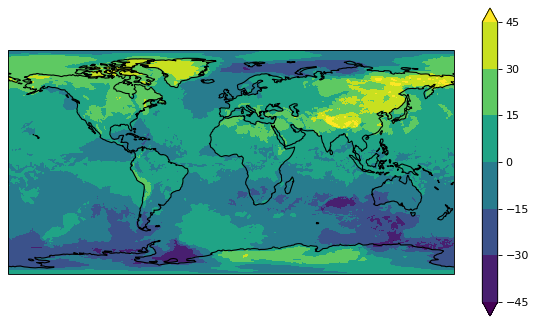

In [ ]:
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=1)

C=plt.contourf(lon,lat,t_hres[0,:,:] - t_era5[0,:,:], extend='both')
plt.colorbar()

In [ ]:
# ============================ ORIGINAL COLAB TEXT AND SCRATCH PAPER =============================

In [ ]:
variables = ['2m_temperature', 'geopotential', '10m_u_component_of_wind', '10m_v_component_of_wind']

target_data_loader_era5 = xarray_loaders.TargetsFromXarray(
    path=target_path_era5,
    variables=variables,
)
target_data_loader_hres = xarray_loaders.TargetsFromXarray(
    path=target_path_hres,
    variables=variables,
)
prediction_data_loader_pangu = xarray_loaders.PredictionsFromXarray(
    path=prediction_path_pangu,
    variables=variables,
)
prediction_data_loader_graphcast = xarray_loaders.PredictionsFromXarray(
    path=prediction_path_graphcast,
    variables=variables,
)
prediction_data_loader_fuxi = xarray_loaders.PredictionsFromXarray(
    path=prediction_path_fuxi,
    variables=variables,
)


/usr/local/lib/python3.11/dist-packages/weatherbenchX/data_loaders/xarray_loaders.py:97: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  self._ds = xr.open_zarr(path)
/usr/local/lib/python3.11/dist-packages/weatherbenchX/data_loaders/xarray_loaders.py:97: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  self._ds = xr.open_zarr(path)
/usr/local/lib/python3.11/dist-packages/weatherbenchX/data_loaders/xarray_loaders.py:97: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  self._ds = xr.open_zarr(path)


Now we define the initialization and lead times we would like to load data for. In the beam pipeline, this would be the job of the TimeChunks instance. For now, let's load two init and three lead times, defined as numpy datetime64/timedelta64 objects.

In [ ]:
#init_times = np.array(['2020-01-01T00', '2020-01-01T12'], dtype='datetime64[ns]')
#lead_times = np.array([6, 12, 18], dtype='timedelta64[h]').astype('timedelta64[ns]')   # To silence xr warnings.
init_times = np.array(['2020-01-01T00'], dtype='datetime64[ns]')
lead_times = np.array([6, 12, 18, 24, 30, 36, 42], dtype='timedelta64[h]').astype('timedelta64[ns]')   # To silence xr warnings.

In [ ]:
target_chunk_era5 = target_data_loader_era5.load_chunk(init_times, lead_times)
target_chunk_hres = target_data_loader_hres.load_chunk(init_times, lead_times)
prediction_chunk_pangu = prediction_data_loader_pangu.load_chunk(init_times, lead_times)
prediction_chunk_graphcast = prediction_data_loader_graphcast.load_chunk(init_times, lead_times)
prediction_chunk_fuxi = prediction_data_loader_fuxi.load_chunk(init_times, lead_times)

Here we can see that the data loader took care of aligning the datasets, i.e. the target data (ERA5) has already been assigned an init and lead time coordinate.

## Metrics

Next, we define the metrics to compute.

In [ ]:
metrics = {
  'rmse': deterministic.RMSE(),
  'mae': deterministic.MAE(),
}

Computing metrics happens in two steps. First, each metric defines one or several statistics that are required for computing the metric. A statistic is defined for each element of the prediction and target arrays, so e.g. for every init time, lead time, latitude and longitude.

In the case of RMSE, the statistic would be the Squared Error.

In [ ]:
metrics['rmse'].statistics

{'SquaredError': <weatherbenchX.metrics.deterministic.SquaredError at 0x78874b917190>}

The helper function below computes all the statistics for a dictionary of metrics. If several metrics use the same underlying statistic (e.g. RMSE and MSE), the statistic is only computed once. This requires all statistics to have unique names, which they define themselves (more on that later).

In [ ]:
statistics = metrics_base.compute_unique_statistics_for_all_metrics(
  metrics, prediction_chunk_pangu, target_chunk_era5
)

In [ ]:
statistics.keys()

dict_keys(['SquaredError', 'AbsoluteError'])

## Aggregation

Then we average the statistics over the desired dimensions. In this simple case, we could just call stat.mean(dims). However, eventually the aggegation will have to happen over many chunks in the beam pipeline.

To allow for multi-step aggregation, we first define an aggregator to reduce over a set of dimensions reduce_dims.

In [ ]:
aggregator = aggregation.Aggregator(
  reduce_dims=['init_time', 'latitude', 'longitude'],
)

In [ ]:
aggregation_state = aggregator.aggregate_statistics(statistics)

The aggregator then aggregates the statistics and produces an aggregation state. An aggregation state contains the sum of the aggregated statistics and the sum of the aggregated weights (without any additional weighting, this will just be 1 for each element in the original statistic arrays). These two can later be summed over many beam chunks.

To get the final averaged statistics, we then divide the aggregated statistics over the aggregated weights. We can simple use the .mean_statistics() method for this.

In [ ]:
aggregation_state.mean_statistics()

{'SquaredError': {'2m_temperature': <xarray.DataArray '2m_temperature' (lead_time: 7)> Size: 28B
  array([0.6442504 , 0.99502146, 1.322167  , 0.99002373, 1.2770338 ,
         1.548182  , 1.6673326 ], dtype=float32)
  Coordinates:
    * lead_time  (lead_time) timedelta64[ns] 56B 0 days 06:00:00 ... 1 days 18:...,
  'geopotential': <xarray.DataArray 'geopotential' (lead_time: 7, level: 13)> Size: 364B
  array([[ 1374.2526,  1867.8287,  1484.7534,  3050.3477,  3266.1357,
           6541.759 ,  7976.4595, 11904.142 ,  6592.2954,  9922.814 ,
           5420.7607,  1164.9019,  3686.6782],
         [ 3406.8552,  4359.3076,  3298.7275,  6191.903 ,  6306.2104,
          12618.643 , 15489.023 , 24019.486 , 15528.692 , 19971.42  ,
          11145.326 ,  2917.6826,  7352.194 ],
         [ 3935.8206,  4925.0176,  3722.886 ,  7130.6436,  7292.0005,
          15422.282 , 19322.066 , 30817.184 , 21878.186 , 26417.262 ,
          15340.327 ,  4885.9233, 11501.537 ],
         [ 3940.2776,  4060.8606,  4

The final step in computing the metrics is to now call the .value_from_mean_statistics() method for each metric, that takes the averaged statistics and converts it to the final metric. In the case of the RMSE, this would be taking the square root of the averaged squared error.

The aggregation state has a handy shortcut for this that also packs up all metrics into a single Dataset with naming convention: `<metric>.<variable>`

In [ ]:
aggregation_state.metric_values(metrics)

<xarray.Dataset> Size: 1kB
Dimensions:                       (lead_time: 7, level: 13)
Coordinates:
  * lead_time                     (lead_time) timedelta64[ns] 56B 0 days 06:0...
  * level                         (level) int64 104B 1000 925 850 ... 150 100 50
Data variables:
    rmse.10m_v_component_of_wind  (lead_time) float32 28B 0.4703 0.721 ... 1.187
    rmse.2m_temperature           (lead_time) float32 28B 0.8027 ... 1.291
    rmse.geopotential             (lead_time, level) float32 364B 37.07 ... 1...
    rmse.10m_u_component_of_wind  (lead_time) float32 28B 0.4688 ... 1.176
    mae.10m_v_component_of_wind   (lead_time) float32 28B 0.3249 ... 0.7985
    mae.2m_temperature            (lead_time) float32 28B 0.4048 ... 0.7265
    mae.geopotential              (lead_time, level) float32 364B 16.53 ... 9...
    mae.10m_u_component_of_wind   (lead_time) float32 28B 0.3239 ... 0.7939

This may seem like a lot of separate steps to get to the final result. This is necessary because, in many use cases, the computation will be parallelized over many chunks. There is a shortcut function for a single chunks that includes the steps above:

In [ ]:
aggregation.compute_metric_values_for_single_chunk(
    metrics,
    aggregator,
    prediction_chunk,
    target_chunk
)

<xarray.Dataset> Size: 412B
Dimensions:              (lead_time: 3, level: 13)
Coordinates:
  * lead_time            (lead_time) timedelta64[ns] 24B 06:00:00 ... 18:00:00
  * level                (level) int32 52B 50 100 150 200 ... 700 850 925 1000
Data variables:
    rmse.geopotential    (lead_time, level) float32 156B 75.49 37.59 ... 39.83
    rmse.2m_temperature  (lead_time) float32 12B 0.7882 0.8575 0.8415
    mae.geopotential     (lead_time, level) float32 156B 63.8 29.22 ... 29.05
    mae.2m_temperature   (lead_time) float32 12B 0.4815 0.5126 0.5184

## Weighting and Binning

This is already it for the simplest example. However, in many cases, we might want more fine-grained aggregation.

One common case is weighting each element differently in the aggregation. For lat-lon datasets, for example, it is common to weigh each grid point by area. This can be done using a GridAreaWeighting object.

In [ ]:
weigh_by = [weighting.GridAreaWeighting()]

Another common case is futher subdividing the aggregation, e.g. computing metrics for several regions. This is done using binning instances.

Important: Make sure the longitude conventions (-180 to 180 or 0 to 360) match between the data and the regions.

In [ ]:
regions = {
    # ((lat_min, lat_max), (lon_min, lon_max))
    'global': ((-90, 90), (0, 360)),
    'india':   ((8,38),(68,98)), # rounded to integer
}
#'na': ((24.08, 50), (360 - 126, 360 - 65)),
#'europe': ((35, 71), (360 - 10, 36)),
bin_by = [binning.Regions(regions)]

In [ ]:
aggregator = aggregation.Aggregator(
  reduce_dims=['init_time', 'latitude', 'longitude'],
  bin_by=bin_by,
  weigh_by=weigh_by,
)
aggregation.compute_metric_values_for_single_chunk(
    metrics,
    aggregator,
    prediction_chunk_pangu,
    target_chunk_era5
)

<xarray.Dataset> Size: 2kB
Dimensions:                       (lead_time: 7, region: 2, level: 13)
Coordinates:
  * lead_time                     (lead_time) timedelta64[ns] 56B 0 days 06:0...
  * region                        (region) <U6 48B 'global' 'india'
  * level                         (level) int64 104B 1000 925 850 ... 150 100 50
Data variables:
    rmse.10m_v_component_of_wind  (lead_time, region) float32 56B 0.4665 ... ...
    rmse.2m_temperature           (lead_time, region) float32 56B 0.6098 ... ...
    rmse.geopotential             (lead_time, level, region) float32 728B 22....
    rmse.10m_u_component_of_wind  (lead_time, region) float32 56B 0.4609 ... ...
    mae.10m_v_component_of_wind   (lead_time, region) float32 56B 0.3211 ... ...
    mae.2m_temperature            (lead_time, region) float32 56B 0.3555 ... ...
    mae.geopotential              (lead_time, level, region) float32 728B 14....
    mae.10m_u_component_of_wind   (lead_time, region) float32 56B 0.3169 ... ...

The results will now have an additional dimension for the region bins.

## Beam pipeline

Now let's put this same example into a beam pipeline that could be scaled to much larger datasets.

The first step in defining a beam pipeline is to define the time chunks. The beam computation will be split into chunks according to init/lead time chunks. Currently, only chunking over the two time dimensions is supported (i.e. not over other coordinates like latitude or longitude).

To define these, there is a TimeChunks class that handles the chunking.

Let's define a range of 4 init and 3 lead times.

In [ ]:
init_times = np.arange('2020-01-01T00', '2020-01-03T00', np.timedelta64(12, 'h'), dtype='datetime64[ns]')
lead_times = np.arange(0, 18, 6, dtype='timedelta64[h]').astype('timedelta64[ns]')
init_times, lead_times

(array(['2020-01-01T00:00:00.000000000', '2020-01-01T12:00:00.000000000',
        '2020-01-02T00:00:00.000000000', '2020-01-02T12:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([             0, 21600000000000, 43200000000000],
       dtype='timedelta64[ns]'))

Now we need to tell the time chunker what chunk sizes to use in init/lead time.

The time chunker is an iterator that returns the appropriate init/lead time chunks for the chosen chunk sizes.



In [ ]:
times = time_chunks.TimeChunks(
  init_times,
  lead_times,
  init_time_chunk_size=2,
  lead_time_chunk_size=1
)
next(iter(times))

(array(['2020-01-01T00:00:00.000000000', '2020-01-01T12:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0], dtype='timedelta64[ns]'))

Finally we can pass all these arguments to define_pipeline(). This will set up the beam pipline. The metric results will be saved as a NetCDF file.

In [ ]:
root = beam.Pipeline(runner='DirectRunner')
beam_pipeline.define_pipeline(
    root=root,
    times=times,
    predictions_loader=prediction_data_loader,
    targets_loader=target_data_loader,
    metrics=metrics,
    aggregator=aggregator,
    out_path='./out.nc',
)
root.run()

In [ ]:
xr.open_dataset('./out.nc').compute()

<xarray.Dataset> Size: 2kB
Dimensions:              (level: 13, region: 3, lead_time: 3)
Coordinates:
  * level                (level) int32 52B 50 100 150 200 ... 700 850 925 1000
  * region               (region) object 24B 'global' 'na' 'europe'
  * lead_time            (lead_time) timedelta64[ns] 24B 00:00:00 ... 12:00:00
Data variables:
    rmse.geopotential    (region, lead_time, level) float64 936B 82.88 ... 29.48
    mae.geopotential     (region, lead_time, level) float64 936B 74.44 ... 22.35
    rmse.2m_temperature  (region, lead_time) float64 72B 0.6832 ... 0.6497
    mae.2m_temperature   (region, lead_time) float64 72B 0.3887 ... 0.4813

Voila! To see an example of a full pipeline, see [run_example_evaluation.py](https://github.com/google-research/weatherbenchX/tree/main/evaluation_scripts/run_example_evaluation.py)

This was it for the simple example. For more advanced topics see the HOW TO guides.